In [2]:
# add parent directory to path
import sys
sys.path.append('..')
import dynasim

import numpy as np
import torch

import findiff

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/marcus/My Drive/Work/eth/experiments/dynamic-pinns/simulator_tests/../dynasim/base.py:80: UserWarning: No initial conditions provided, proceeding with zero initial state
  warnings.warn('No initial conditions provided, proceeding with zero initial state', UserWarning)


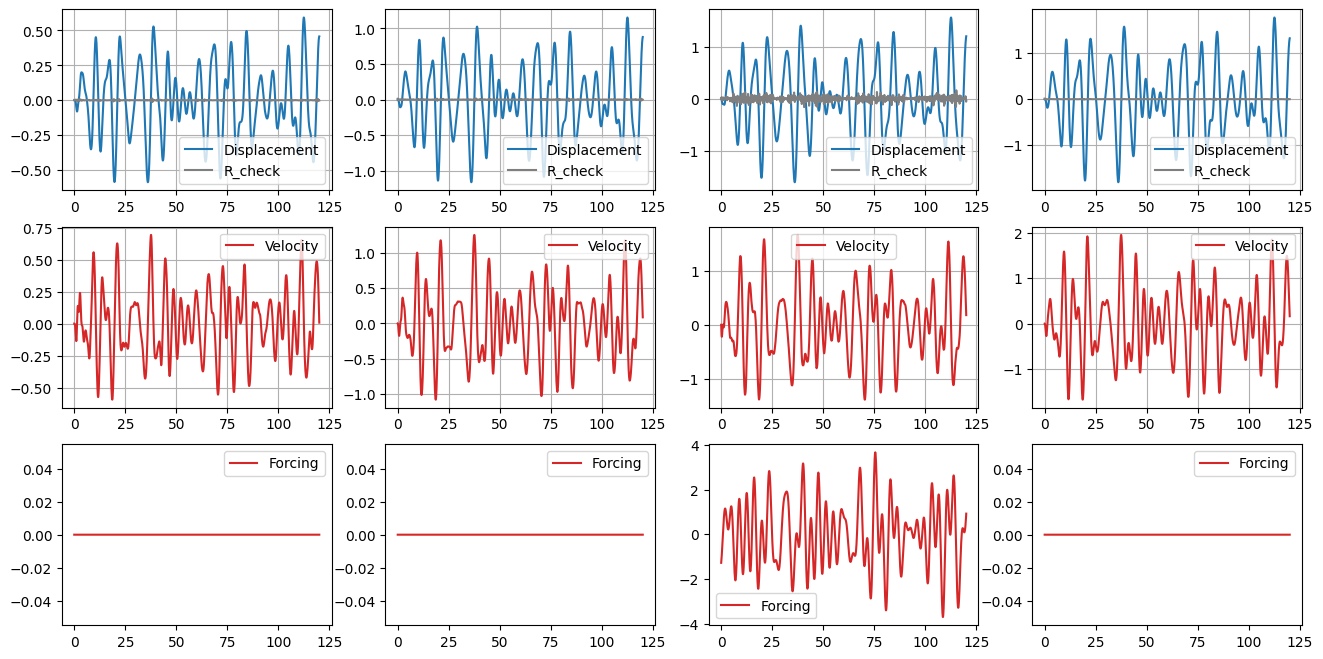

In [3]:
nt = 2048
tt = np.linspace(0,120,nt)
F0 = 1.0  # N
n_dof = 4

# set physical parameters
k1 = 10.0
c1 = 0.25
m1 = 1.0
kn_ = np.zeros((n_dof))
kn_[0] = 2.0
cn_ = np.zeros((n_dof))
cn_[0] = 0.000001

# create nonlinearity
cubic_nonlin = dynasim.nonlinearities.exponent_stiffness(kn_, exponent=3, dofs=n_dof)
# cubic_nonlin = dynasim.nonlinearities.exponent_damping(cn_, exponent=0.5, dofs=n_dof)

# instantiate system
system = dynasim.systems.cantilever(m1, c1, k1, dofs=n_dof, nonlinearity=cubic_nonlin)

# generate excitations
system.excitations = [
    None,
    None,
    dynasim.actuators.rand_phase_ms(
        freqs = np.array([0.7, 0.85, 1.6, 1.8]),
        Sx = np.ones(4)
    ),
    None]

x0 = np.array([-2.0, 0.0, 0.0, 3.0])
v0 = np.array([-2.0, 0.0, 0.0, 0.0])
z0 = np.concatenate((x0, v0), axis=0)

data = system.simulate(tt, z0=None)

xx, vv = data['x'], data['xdot']
F = system.f

dt = tt[1]-tt[0]
d_dt = findiff.FinDiff(0,dt)
aa = d_dt(vv.T).T
state_gt = np.concatenate((xx,vv),axis=0)
state_gt_dot = np.concatenate((vv,aa),axis=0)
zn = system.nonlin_transform(state_gt)

M, C, K = system.M, system.C, system.K
Kn = system.Kn
Cn = system.Cn
An = np.concatenate((
    np.concatenate((np.zeros((n_dof,n_dof)),np.eye(n_dof)), axis=1),
    np.concatenate((-np.linalg.inv(M)@Kn, -np.linalg.inv(M)@Cn), axis=1)
    ), axis=0)
A = np.concatenate((
    np.concatenate((np.zeros((n_dof,n_dof)),np.eye(n_dof)), axis=1),
    np.concatenate((-np.linalg.inv(M)@K, -np.linalg.inv(M)@C), axis=1)
    ), axis=0)
H = np.concatenate((np.zeros((n_dof,n_dof)),np.linalg.inv(M)), axis=0)

if system.excitations is None:
    R_check = (state_gt_dot - A@state_gt - An@zn)[n_dof:,:]
else:
    R_check = (state_gt_dot - A@state_gt - An@zn - H@F)[n_dof:,:]

if n_dof > 4:
    sub_rows = n_dof // 4 + int((n_dof%4)!=0)
    sub_cols = 4
else:
    sub_rows = 1
    sub_cols = n_dof

fig, axs = plt.subplots(3*sub_rows,sub_cols,figsize=(4*sub_cols,8*sub_rows))
p_count = 0
for j in range(sub_rows):
    for i in range(sub_cols):
        axs[j*3,i].plot(tt, xx[p_count,:], color="tab:blue", label="Displacement")
        # axs[j*3,i].set_ylim((-2.5,3))
        axs[j*3,i].grid()
        axs[j*3,i].plot(tt, R_check[p_count,:], color="tab:gray", label="R_check")
        axs[j*3,i].legend()

        axs[j*3+1,i].plot(tt, vv[p_count,:], color="tab:red", label="Velocity")
        # axs[j*3+1,i].set_ylim((-10,10))
        axs[j*3+1,i].grid()
        axs[j*3+1,i].legend()

        axs[j*3+2,i].plot(tt, F[p_count,:], color="tab:red", label="Forcing")
        # axs[j*3+2,i].plot(tt, aa[p_count,:], color="tab:red", label="Acceleration")
        axs[j*3+2,i].legend()
        
        p_count += 1

        if p_count == n_dof:
            break